```
This notebook runs small ensembles in the Oslo fjord where we perturb a
single parameter for each ensemble to look at the resulting variance 
and how it affects a drift trajectory.

Copyright (C) 2022 - 2023 SINTEF Digital
Copyright (C) 2022 - 2023 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 711902d818931f354021a809b5b19626dc97837e on branch reduced_gravity


In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display
import xarray as xr


#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

from gpuocean.SWEsimulators import CDKLM16

from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [4]:
%cuda_context_handler gpu_ctx

### Read input file and typical parameters

In [5]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"
# source_url = "/lustre/storeB/project/fou/hi/FjordOs/geogrid_tmp/test_polstere_1h_0007.nc"
nc = Dataset(source_url)
ds = xr.open_dataset(source_url)

# Grid and discretization
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [6]:
t_start = 5*24 +20#285
t_stop =  t_start + 6
T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]


In [7]:
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/17)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    Uwind       (ocean_time, eta_rho, xi_rho) float32 ...
    Vwind       (ocean_time, eta_rho, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

# Reference values

In [8]:
timestep_indices0 = [[140, 141]]
timestep_indices1 = [[141]]

In [9]:
# Baroclinic initial conditions
barotropic_data_args, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1022.0, timestep_indices=timestep_indices0, norkyst_data=False, land_value=0.0, download_data=False)
_, ref_baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url, x0, x1, y0, y1, 1022.0, timestep_indices=timestep_indices1, norkyst_data=False, land_value=0.0, download_data=False)

In [10]:
baroclinic_data_args["r"] = 0.0

In [12]:
ref_wind = baroclinic_data_args["wind"]
ref_wind.wind_u[ref_wind.wind_u > 1e3] = 0.0
ref_wind.wind_v[ref_wind.wind_v > 1e3] = 0.0
ref_wind.compute_wind_stress_from_wind()

baroclinic_data_args["wind"] = ref_wind
baroclinic_data_args["wind_stress_factor"] = 0.5

In [13]:
# tmp_eta = baroclinic_data_args["eta0"].copy()
# mean_eta = np.ma.mean(tmp_eta)
# mean_eta

In [14]:
baroclinic_data_args["eta0"].min()

1.5

In [15]:
sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0)
sim.step(3600)


This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


3600.0

In [16]:
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(20,7), interior=False, eta_lim = 10, uv_lim=0.5):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    range_eta = eta_lim
    range_huv = uv_lim
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$h$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$u$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$v$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)

In [17]:
init_u = baroclinic_data_args["hu0"]/baroclinic_data_args["eta0"]
init_v = baroclinic_data_args["hv0"]/baroclinic_data_args["eta0"]

ref_u = ref_baroclinic_data_args["hu0"]/ref_baroclinic_data_args["eta0"]
ref_v = ref_baroclinic_data_args["hv0"]/ref_baroclinic_data_args["eta0"]

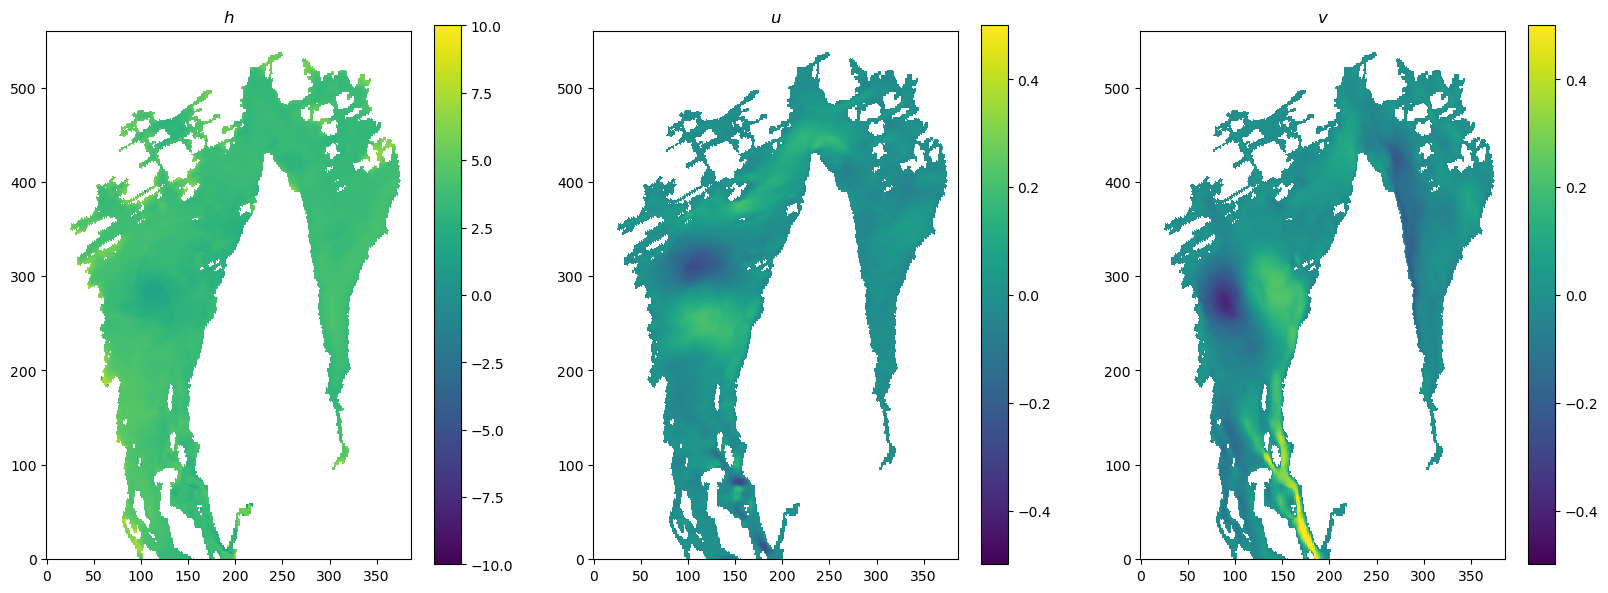

In [18]:
imshow3(baroclinic_data_args["eta0"], init_u, init_v)


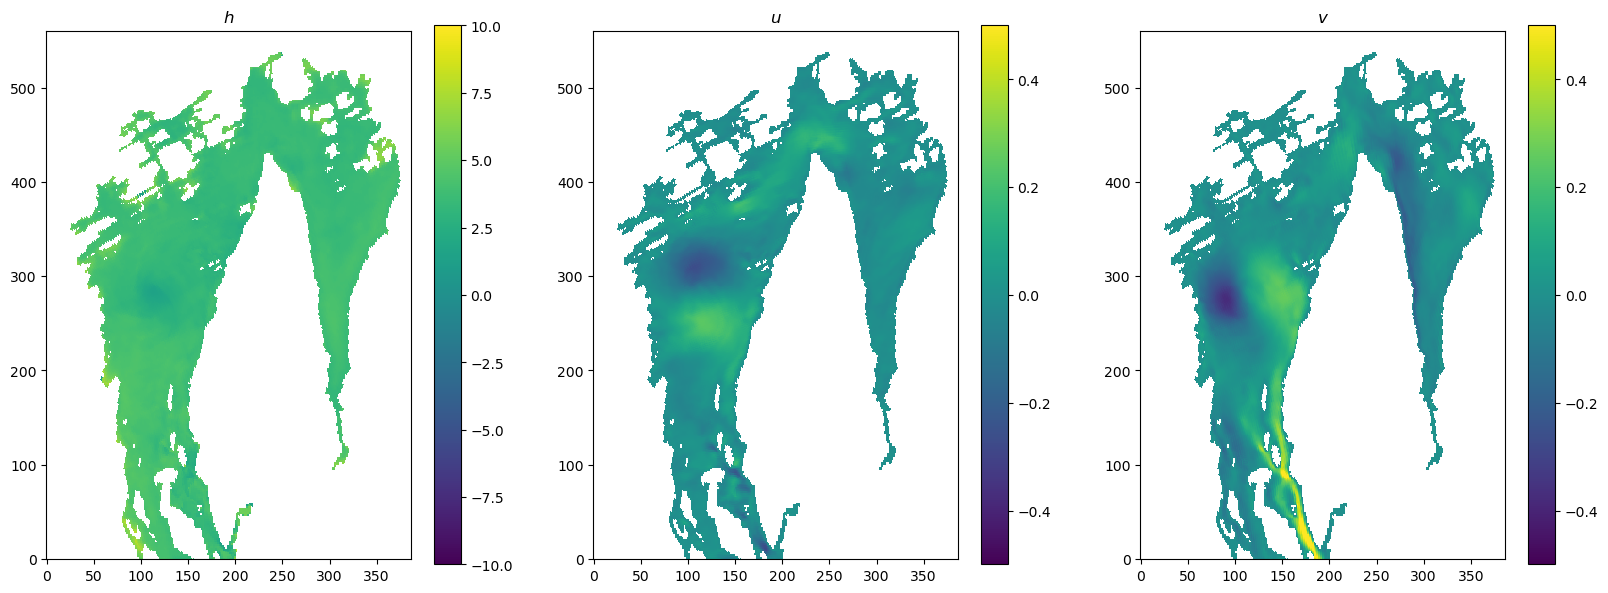

In [19]:
imshow3(ref_baroclinic_data_args["eta0"], ref_u, ref_v)

Text(0.5, 0.98, 'Friction zero, original eta')

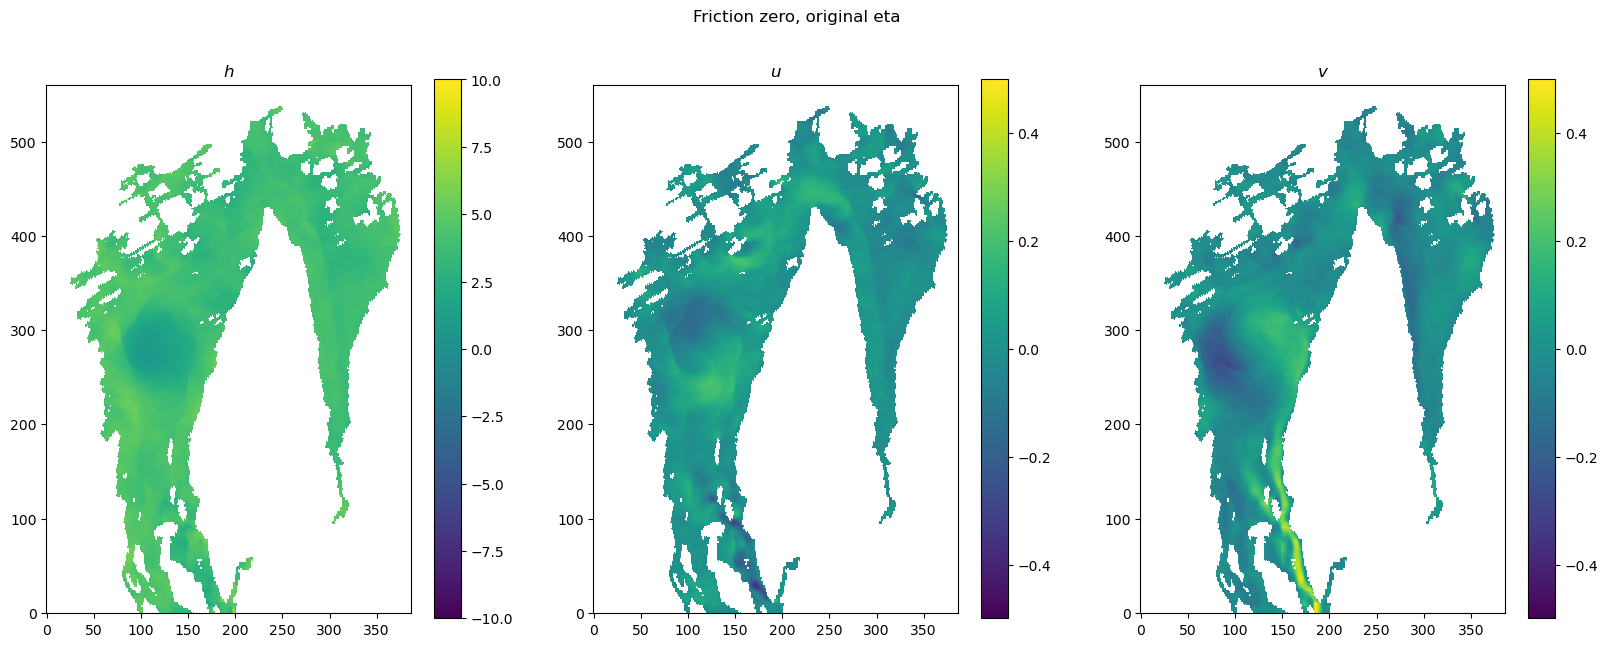

In [20]:
eta, hu, hv = sim.download()

u = hu/eta
v = hv/eta
imshow3(eta, u, v)
plt.suptitle("Friction zero, original eta")

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


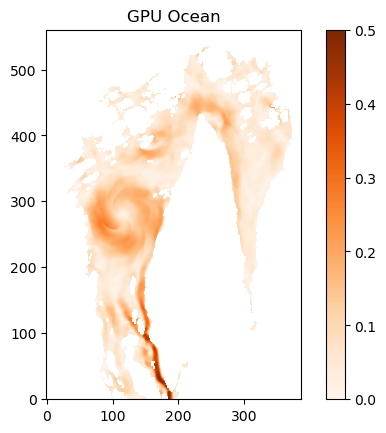

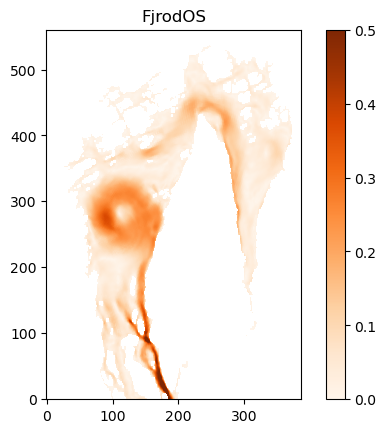

In [21]:
plt.imshow(np.sqrt(u**2+v**2), vmin=0, vmax=0.5, cmap="Oranges")
plt.title("GPU Ocean")
plt.colorbar()
plt.figure()
plt.imshow(np.sqrt(ref_u**2+ref_v**2), vmin=0, vmax=0.5, cmap="Oranges")
plt.title("FjrodOS")
plt.colorbar()

In [40]:
dim_x = baroclinic_data_args["nx"]*baroclinic_data_args["dx"]
dim_y = baroclinic_data_args["ny"]*baroclinic_data_args["dy"]

def _plot_field(field, dims,
                cmap=plt.cm.Reds, vmin=0.0, vmax=0.5, filename=None, cbar=True, cbar_label=None, 
                quiver=None):
    
    with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
        fig, ax = plt.subplots(1,1, figsize=(10,10))

        domain_extent = [0, dims[0]/1000, 0, dims[1]/1000]

        cmap_cp = copy.copy(cmap)
        cmap_cp.set_bad("grey", alpha = 1.0)

        im = ax.imshow(field, interpolation="none", origin='lower', 
                       cmap=cmap_cp, 
                       vmin=vmin, vmax=vmax, 
                       extent=domain_extent)

        ax.tick_params(axis='both', which='major', labelsize=28)

        try:
            lat = np.array(nc.variables["lat_rho"])
            lon = np.array(nc.variables["lon_rho"])

            spec_lat = lat[y0:y1, x0:x1]
            spec_lon = lon[y0:y1, x0:x1]

            cont_lon_case = ax.contour(spec_lon, levels = np.arange( 0, 30, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)
            cont_lat_case = ax.contour(spec_lat, levels = np.arange(30, 80, 0.1), extent=domain_extent, colors='k', alpha=0.2, linewidths=0.8, zorder=1)

        except Exception as e:
            raise e


        if quiver is not None:
            ax.quiver(quiver[0], quiver[1], quiver[2], quiver[3], scale=5)

        if cbar:
            cb = plt.colorbar(im)#, ax=ax, shrink=0.9, pad=0.15) #, shrink=0.8)
            cb.ax.tick_params(labelsize=28)
            cb.formatter.set_powerlimits((-2, 2))
            cb.formatter.set_useMathText(True)
            cb.ax.yaxis.offsetText.set_fontsize(36)

        if cbar and cbar_label is not None:
            cb.set_label(label=cbar_label, size=36, labelpad=25)
        
        plt.tight_layout()

        if filename is not None:
            plt.savefig( filename+".pdf", bbox_inches="tight")


/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


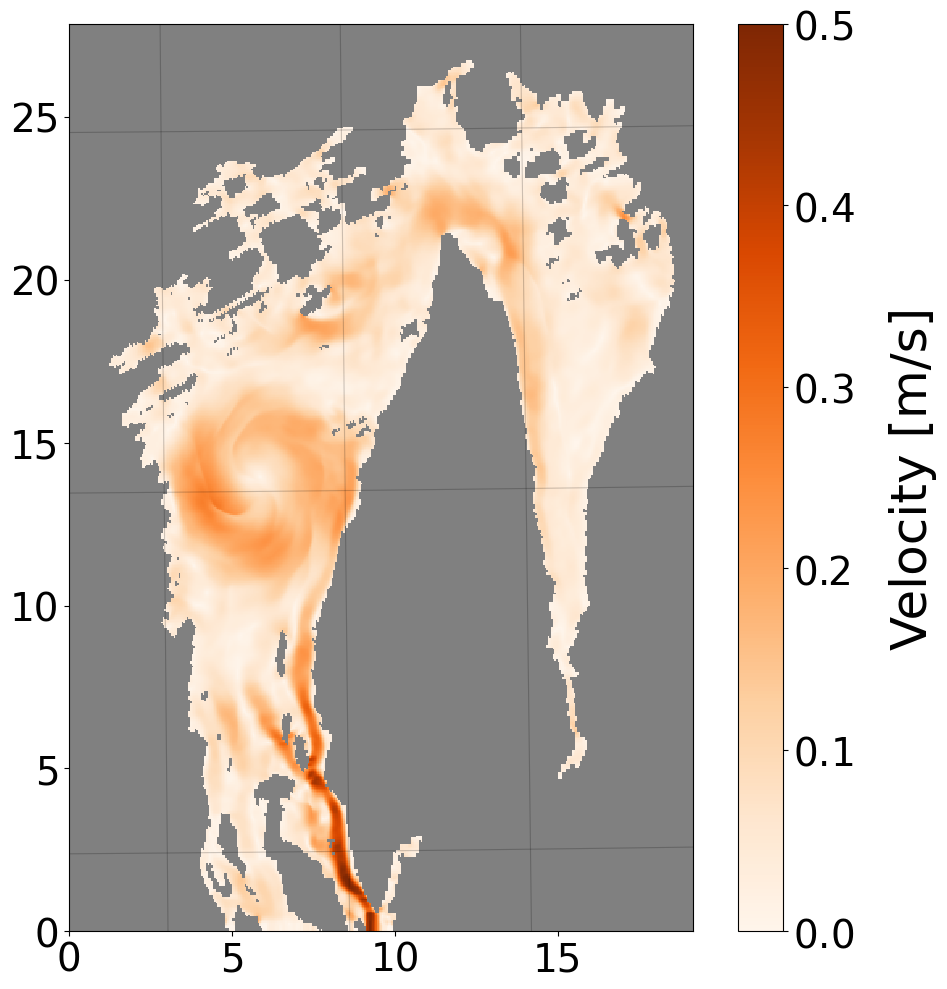

In [41]:
_plot_field(np.sqrt(u**2+v**2), [dim_x, dim_y], cmap=plt.cm.Oranges, cbar_label="Velocity [m/s]", filename="Oslofjord-Validation-GPUOcean")

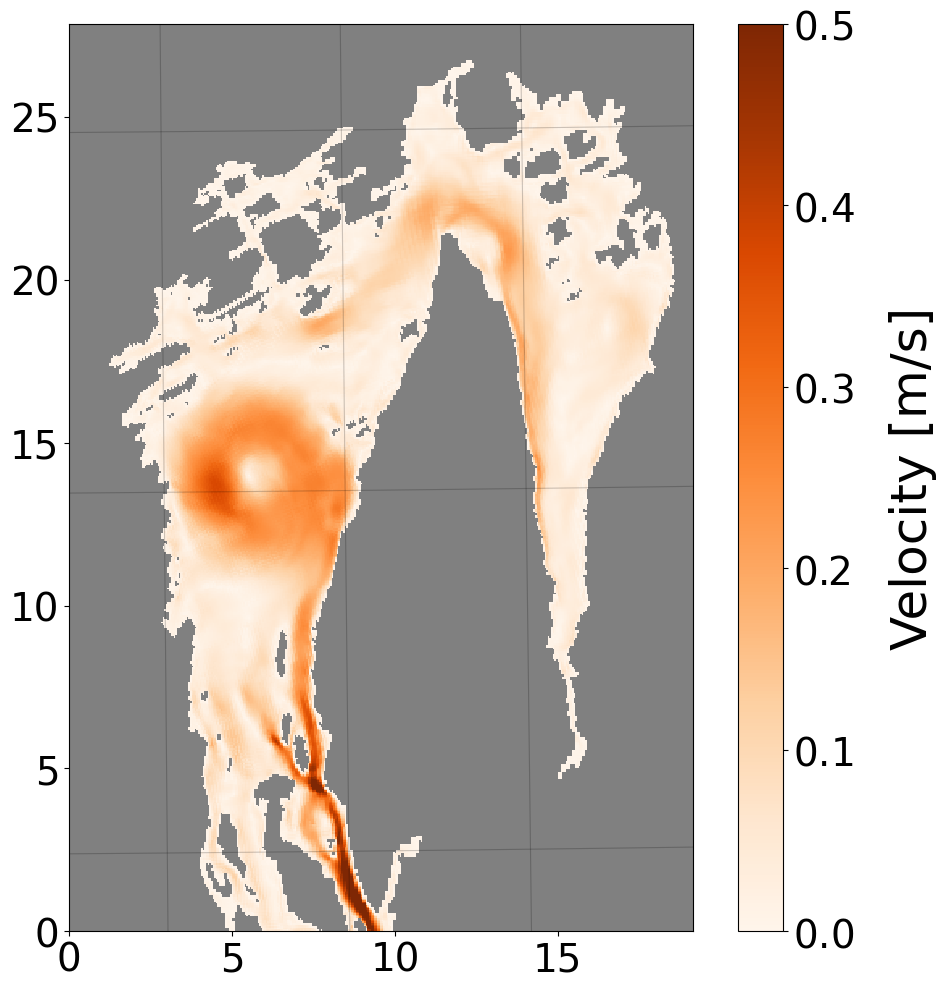

In [42]:
_plot_field(np.sqrt(ref_u**2+ref_v**2), [dim_x, dim_y], cmap=plt.cm.Oranges, cbar_label="Velocity [m/s]", filename="Oslofjord-Validation-FjordOS")

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


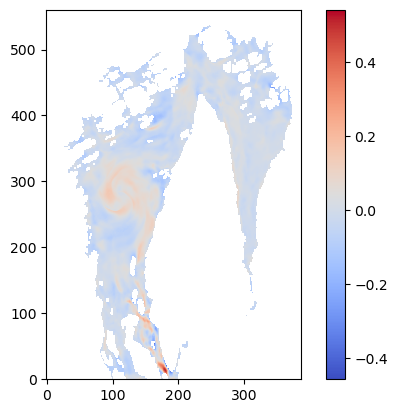

In [ ]:
plt.imshow(np.sqrt(ref_u**2+ref_v**2)- np.sqrt(u**2+v**2), cmap="coolwarm")
plt.colorbar()

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Text(0.5, 0.98, 'Friction zero, sharper eta')

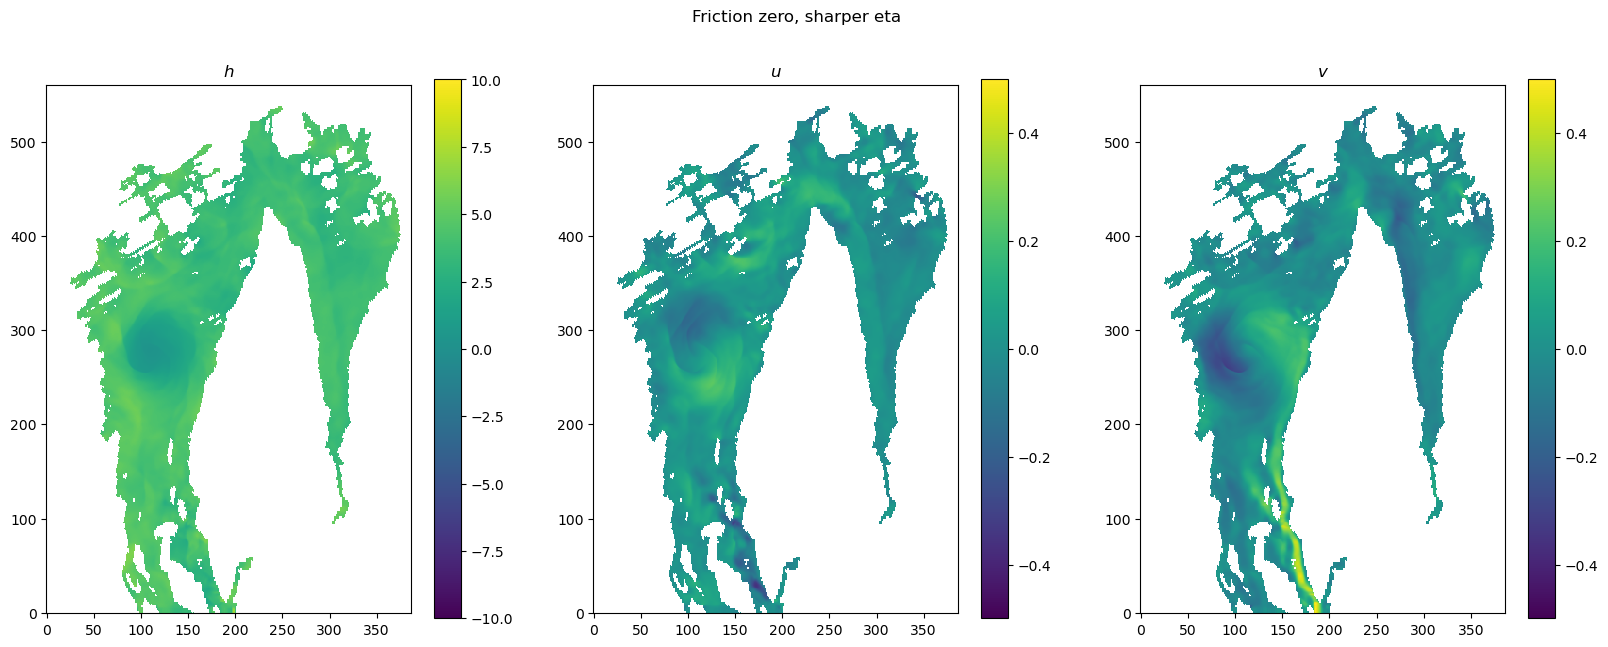

In [ ]:
baroclinic_data_args["eta0"] = (tmp_eta - mean_eta)*1.3 + mean_eta
sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(baroclinic_data_args),  dt=0.0)
sim.step(3600)
eta, hu, hv = sim.download()

u = hu/eta
v = hv/eta
imshow3(eta, u, v)
plt.suptitle("Friction zero, sharper eta")

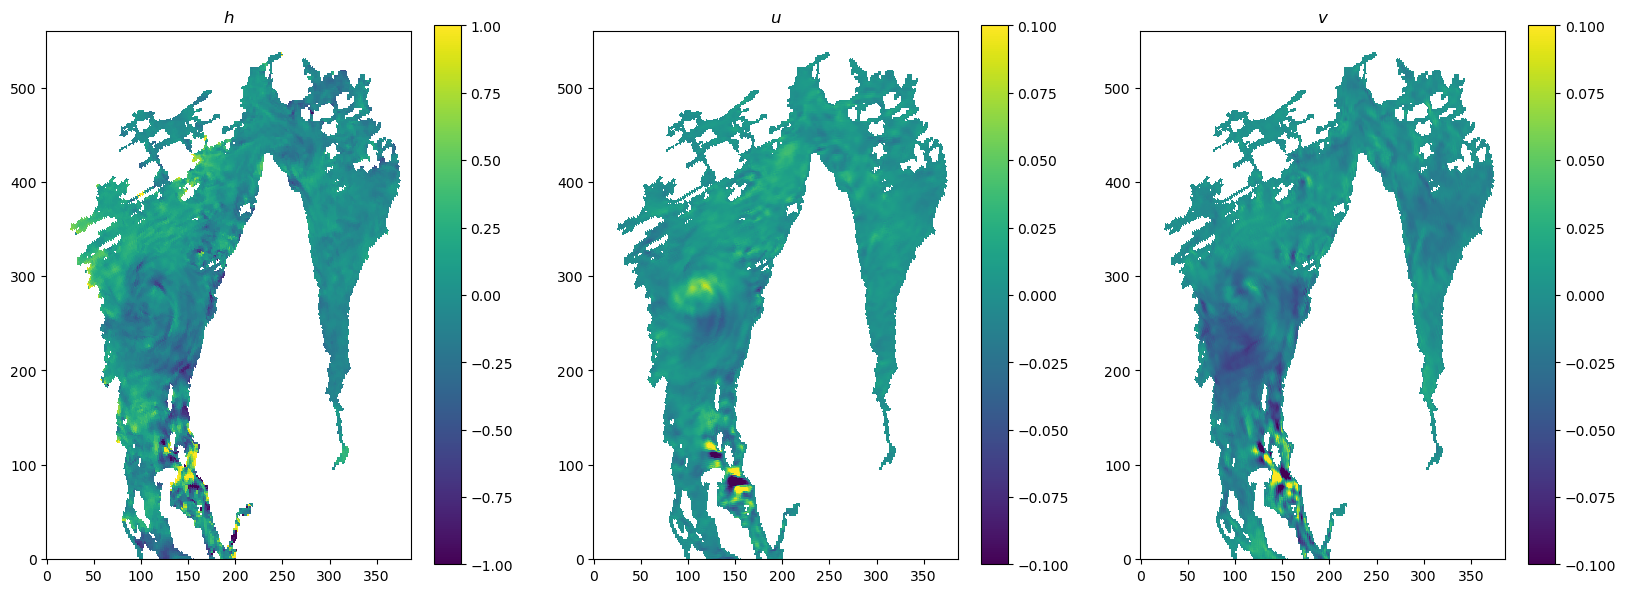

In [ ]:
imshow3(baroclinic_data_args["eta0"] - ref_baroclinic_data_args["eta0"], init_u - ref_u, init_v - ref_v, eta_lim=1, uv_lim=0.1)

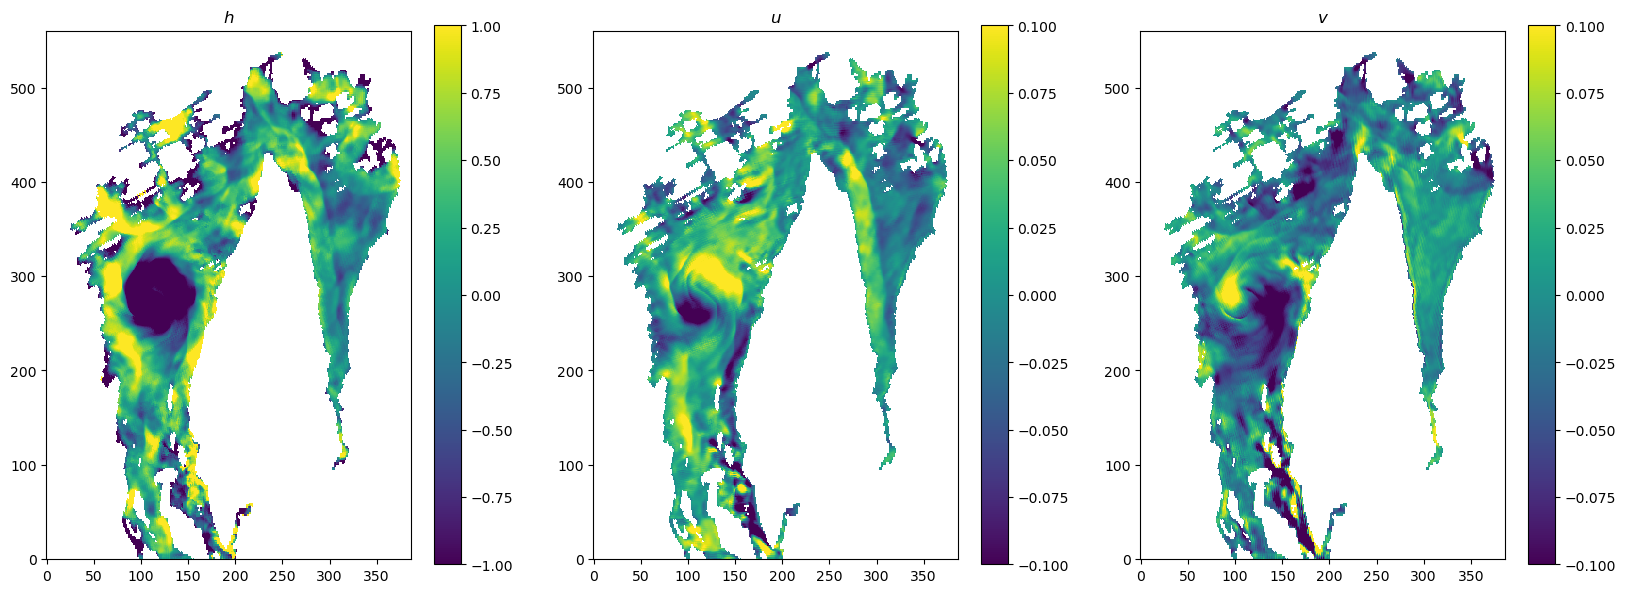

In [ ]:

imshow3(eta - ref_baroclinic_data_args["eta0"], u - ref_u, v - ref_v, eta_lim=1, uv_lim=0.1)